#### Parse dataset into doctor-only and patient-only text
- Laura's `parseconvos.py`

In [45]:
import pandas as pd
import re
import json




def load_data(dataset_file):
    # Load the JSONL file into a DataFrame
    data = []
    if dataset_file.endswith('.jsonl'):
        with open(dataset_file, "r") as file:
            for line in file:
                data.append(json.loads(line))
        df = pd.DataFrame(data)
    elif dataset_file.endswith('.csv'):
            df = pd.read_csv(dataset_file)
    else:
        raise ValueError("Unsupported file format. Please use .jsonl or .csv.")
    return df

# Define functions to extract dialogues
def extract_doctor_dialogue(text):
    if 'aci' in dataset_file:
        matches = re.findall(r"\[doctor\](.*?)(?=\[patient\]|\Z)", text, re.DOTALL)
       
    elif 'MTS' in dataset_file:
        matches = re.findall(r"Doctor:\s*(.*?)(?=Patient:|\Z)", text, re.DOTALL)

    return ' '.join(matches).strip() if matches else None

def extract_patient_dialogue(text):
    if 'aci' in dataset_file:
        matches = re.findall(r"\[patient\](.*?)(?=\[doctor\]|\Z)", text, re.DOTALL)
    elif 'MTS' in dataset_file:
        matches = re.findall(r"Patient:\s*(.*?)(?=Doctor:|\Z)", text, re.DOTALL)  
    return ' '.join(matches).strip() if matches else None

# Specify input file here
# dataset_file = "data/mts-dialog/MTS_Dataset_TrainingSet.csv"
dataset_file = "data/aci_train.jsonl"
df = load_data(dataset_file)

# Apply the functions to extract dialogues and add as new columns
df['doctor_dialogue'] = df['dialogue'].apply(extract_doctor_dialogue)
df['patient_dialogue'] = df['dialogue'].apply(extract_patient_dialogue)



#### Apply NLTK VADER module to the dialogue
Outputs:
- neg
- neu
- pos
- compound


Note: must run `nltk.downloader.download('vader_lexicon')` first

In [46]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer


nltk.download('vader_lexicon')
def run_nltk_vader(text):
    if text:    
        sid = SentimentIntensityAnalyzer()
        ss = sid.polarity_scores(text)  # Use 'text' here instead of 'sentence'
        return ss['neg'], ss['neu'], ss['pos'], ss['compound']
    else:
        return 0.0, 0.0, 0.0, 0.0

# Apply the function and unpack results into separate columns
df[['doctor_dialogue_neg', 'doctor_dialogue_neu', 'doctor_dialogue_pos', 'doctor_dialogue_compound']] = df['doctor_dialogue'].apply(lambda x: pd.Series(run_nltk_vader(x)))
df[['patient_dialogue_neg', 'patient_dialogue_neu', 'patient_dialogue_pos', 'patient_dialogue_compound']] = df['patient_dialogue'].apply(lambda x: pd.Series(run_nltk_vader(x)))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/laurachen/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


#### Analyzing differences in the `compound` scores
1. Descriptive stats
- Doctor - mean: 0.923, SD: 0.324
- Patient - mean: 0.662, SD: 0.654
2. Paired t-test
- t(66)=2.843
- p=0.006
- Statistically significant
3. Effect size
- Cohen's d for compound sentiment: 0.507
- Moderate effect size
4. Figure
- See below

In [47]:
# 1. Descriptive stats
## Doctor - mean: 0.923, SD: 0.324
## Patient - mean: 0.662, SD: 0.654

doctor_stats = df['doctor_dialogue_compound'].describe()
patient_stats = df['patient_dialogue_compound'].describe()
print("Doctor Sentiment Descriptive Statistics:\n", doctor_stats)
print("\nPatient Sentiment Descriptive Statistics:\n", patient_stats)

Doctor Sentiment Descriptive Statistics:
 count    67.000000
mean      0.923148
std       0.323756
min      -0.922900
25%       0.988300
50%       0.994900
75%       0.997900
max       0.999800
Name: doctor_dialogue_compound, dtype: float64

Patient Sentiment Descriptive Statistics:
 count    67.000000
mean      0.662001
std       0.653064
min      -0.984600
25%       0.813200
50%       0.980300
75%       0.993000
max       0.999500
Name: patient_dialogue_compound, dtype: float64


In [44]:
from scipy import stats

for sentiment in ['neg', 'neu', 'pos', 'compound']:
    stat, p_value = stats.ttest_rel(df[f'doctor_dialogue_{sentiment}'], df[f'patient_dialogue_{sentiment}'])
    print(f"Paired t-test for {sentiment} sentiment: t-statistic={stat:.3f}, p-value={p_value:.3f}")


Paired t-test for neg sentiment: t-statistic=-12.949, p-value=0.000
Paired t-test for neu sentiment: t-statistic=23.751, p-value=0.000
Paired t-test for pos sentiment: t-statistic=-7.689, p-value=0.000
Paired t-test for compound sentiment: t-statistic=4.245, p-value=0.000


In [39]:
for sentiment in ['neg', 'neu', 'pos', 'compound']:
    doctor_mean = df[f'doctor_dialogue_{sentiment}'].mean()
    patient_mean = df[f'patient_dialogue_{sentiment}'].mean()
    pooled_std = ((df[f'doctor_dialogue_{sentiment}'].std() ** 2 + df[f'patient_dialogue_{sentiment}'].std() ** 2) / 2) ** 0.5
    cohen_d = (doctor_mean - patient_mean) / pooled_std
    print(f"Cohen's d for {sentiment} sentiment: {cohen_d:.3f}")

Cohen's d for neg sentiment: -0.496
Cohen's d for neu sentiment: 0.956
Cohen's d for pos sentiment: -0.288
Cohen's d for compound sentiment: 0.146


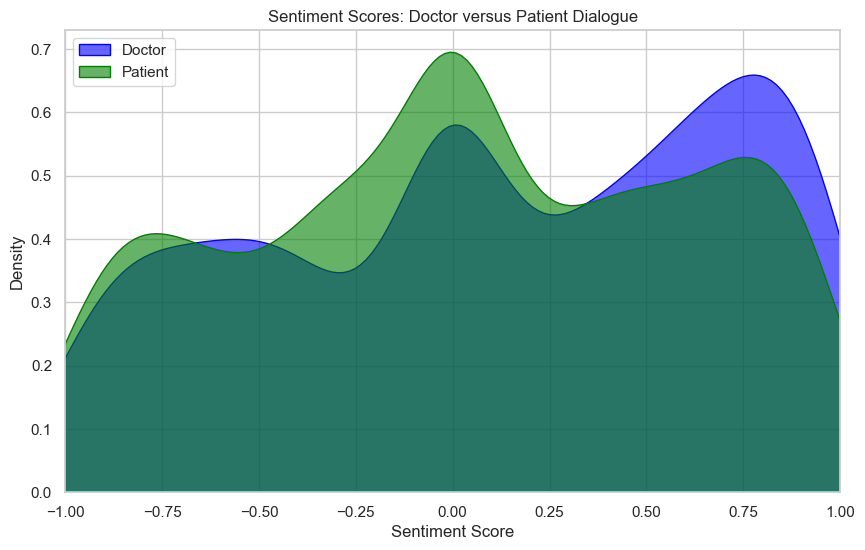

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.kdeplot(df['doctor_dialogue_compound'], fill=True, color='blue', label='Doctor', alpha=0.6)
sns.kdeplot(df['patient_dialogue_compound'], fill=True, color='green', label='Patient', alpha=0.6)

# Adding titles, labels, and setting x-axis limits
plt.title('Sentiment Scores: Doctor versus Patient Dialogue')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.xlim(-1, 1)  # Set x-axis limits to match the range of compound sentiment scores
plt.legend()

plt.show()